<a href="https://colab.research.google.com/github/Tunyalucklie/Gai_implementation/blob/main/LLAma_Gai_implementation_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finetune Llama-2-13b on a Google colab**
Welcome to this Google Colab notebook that shows how to fine-tune the codelama-2-13b model on a single Google colab, leveraging PEFT library from Hugging Face ecosystem, as well as QLoRA for more memory efficient finetuning

# **Prepare Dataset**

code generation dataset

In [ ]:
import pandas as pd

instruction = pd.read_csv('https://raw.githubusercontent.com/Tunyalucklie/Gai_implementation/main/instruction_dataset_codegen3.csv')

In [ ]:
owndata = pd.read_csv('https://raw.githubusercontent.com/Tunyalucklie/Gai_implementation/main/churn.csv')

In [ ]:
train_code = instruction[['instruction','input','output']]
train_code

,instruction,input,output
0,Generate a python script to perform this action.,You will need to create a bar graph with the g...,import pandas as pd \nimport seaborn as sns\n...
1,Generate a python script to perform this action.,This owndata is Telecom customer dataset and h...,import pandas as pd \nimport seaborn as sns\n...
2,Generate a python script to perform this action.,This owndata is Telecom customer dataset and h...,import pandas as pd \nimport seaborn as sns\n...
3,Generate a python script to visualize this act...,This owndata is Telecom customer dataset and h...,import plotly.express as px\ndf = owndata\nfig...
4,Generate a python script to perform this action.,This owndata is Telecom customer dataset and h...,import plotly.express as px\ndf = owndata\nfig...
...,...,...,...
85,Generate a python script to perform this action.,"Using the owndata dataset, your task is to cra...",import pandas as pd \nimport seaborn as sns\n...
86,Generate a python script to perform this action.,"Create a bar graph with the owndata dataset, p...",import pandas as pd \nimport seaborn as sns\n...
87,Generate a python script to perform this action.,"In the owndata dataset, you are required to ge...",import pandas as pd \nimport seaborn as sns\n...
88,Generate a python script to perform this action.,"Utilizing the owndata dataset, construct a bar...",import pandas as pd \nimport seaborn as sns\n...


In [ ]:
train_code_json = train_code.to_json(orient='records', lines=True)
jsonl_file3 = 'output_codegen.jsonl'

with open(jsonl_file3, 'w') as file:
    file.write(train_code_json)

print(f'Data has been converted to {jsonl_file3}')

Data has been converted to output_codegen.jsonl


In [ ]:
train_code_json

'{"instruction":"Generate a python script to perform this action.","input":"You will need to create a bar graph with the gender on the x- axis and churn on the y- axis of owndata dataset.","output":"```python\\nimport pandas as pd  \\nimport seaborn as sns\\n\\ndf = owndata\\nsns.countplot(x=df[\'gender\'])\\n```"}\n{"instruction":"Generate a python script to perform this action.","input":"This owndata is Telecom customer dataset and has columns such as customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, Churn. You will need to create a bar graph with the SeniorCitizen on the x- axis and count on the y- axis.","output":"```python\\nimport pandas as pd  \\nimport seaborn as sns\\n\\ndf = owndata\\nsns.countplot(x=df[\'SeniorCitizen\'])\\n```"}\n{"instruction":"Generate a python script to perform this action.","input":"This owndata is Telecom customer dataset and has columns such as customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, Ch

# **Fine-tuning**

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19

# Load Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Tunyaluck/test_gencode_gai333", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Loading the model


*   The matrix multiplication and training will be faster if one uses a 16-bit compute dtype (default torch.float32)
*   leverage the recent BitsAndBytesConfig from transformers to change parameters to load a model in 4bit using NF4 quantization below with double quantization with the compute dtype float16 for faster training.

In [ ]:
#Loading the model
import torch
from torch import cuda
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

model_name = "codellama/CodeLlama-13b-hf"
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True
)
model.config.use_cache = False

print(f"Model loaded on {device}")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model loaded on cuda:0


In [ ]:
#load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

It is not possible to perform pure 4bit training on these models. However, you can train these models by leveraging parameter efficient fine tuning methods (PEFT) and train for example adapters on top of them.

In [ ]:
from peft import LoraConfig, get_peft_model

# lora_r – the rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters.Lora R. Must be a positive integer. Default is 8.
# lora_alpha –  LoRA scaling factor. Lora Alpha. Must be a positive integer. Default is 32
# lora_dropout – Lora Dropout. must be a positive float between 0 and 1. Default is 0.05.
# bias: Specifies if the bias parameters should be trained. Can be 'none', 'all' or 'lora_only'.

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

#model = get_peft_model(model, peft_config)

# Loading the trainer

Here we will use the [`SFTTrainer` from TRL library](https://huggingface.co/docs/trl/main/en/sft_trainer) that gives a wrapper around transformers `Trainer` to easily fine-tune models on instruction based datasets using PEFT adapters. Let's first load the training arguments below.

In [ ]:
from transformers import TrainingArguments

output_dir = "./results"
per_device_train_batch_size = 4  # The batch size per GPU core/CPU for training. Must be a positive integer. Default is 4.
gradient_accumulation_steps = 4
optim = "paged_adamw_32bit"
save_steps = 50
logging_steps = 10
learning_rate = 2e-4
max_grad_norm = 0.3
max_steps = 60
warmup_ratio = 0.03
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
   # report_to="none"
)

# Training

In [ ]:
#pass everthing to the trainer

from trl import SFTTrainer #, DataCollatorForCompletionOnlyLM
max_seq_length = 1024

def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Instruction: {example['instruction'][i]}\n ### Input: {example['input'][i]}\n ### Answer: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

# response_template = " ### Answer:"
# collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

trainer = SFTTrainer(
    model=model,
    train_dataset= dataset,
    formatting_func = formatting_prompts_func,
#    data_collator=collator,
    args=training_arguments,
    peft_config=peft_config,
    max_seq_length=max_seq_length
)

#We will also pre-process the model by upcasting the layer norms in float 32 for more stable training
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

#training
trainer.train()

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:133: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
Using pad_token, but it is not set yet.


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:207: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a CodeLlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,1.925600
20,1.194500
30,0.460300
40,0.247800
50,0.152600
60,0.105000


TrainOutput(global_step=60, training_loss=0.6809648474057516, metrics={'train_runtime': 1370.6774, 'train_samples_per_second': 0.7, 'train_steps_per_second': 0.044, 'total_flos': 5259961966018560.0, 'train_loss': 0.6809648474057516, 'epoch': 10.43})

# Training Loss

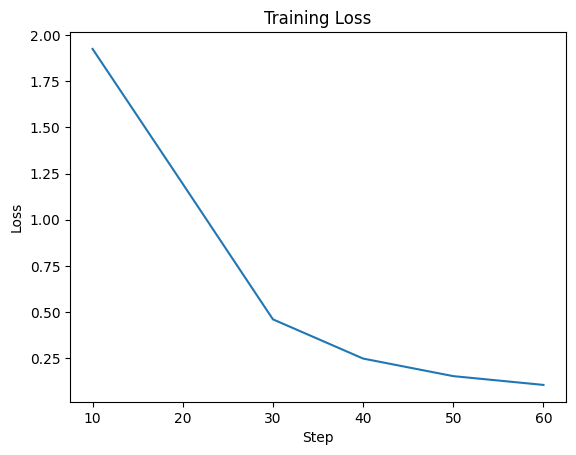

In [ ]:
import pandas as pd
from matplotlib.pylab import plt

loss = pd.DataFrame(trainer.state.log_history)
plt.plot(loss['step'], loss[['loss']], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

# Save fine-tuned model to drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive" )
model_path = "/content/drive/MyDrive/outputs-llama-gen6"

model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained(model_path)

Mounted at /content/drive


# **Load Train Model**

In [ ]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount("/content/drive" )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_path = "/content/drive/MyDrive/outputs-llama-gen4"

In [ ]:
# from torch import cuda
# from peft import LoraConfig, get_peft_model, PeftModel
# from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer

# model = AutoModelForCausalLM.from_pretrained(model_path)

# tokenizer = AutoTokenizer.from_pretrained(model_path)
# tokenizer.pad_token = tokenizer.eos_token


In [ ]:
#model = PeftModel.from_pretrained(model, "./results/checkpoint-10")

In [ ]:
lora_config = LoraConfig.from_pretrained(model_path)
model = get_peft_model(model, lora_config)

In [ ]:
from huggingface_hub import login
login()
model.push_to_hub("llama2-qlora-finetunined-testwithblend")

#Test


In [ ]:
import pandas as pd

owndata = pd.read_csv('https://raw.githubusercontent.com/Tunyalucklie/Gai_implementation/main/churn.csv')

In [ ]:
def get_visualization_code1(text):
  device = "cuda:0"
  instruction = "Generate a python script to perform this action."
  prompt = "### Instruction: "+instruction+ "### Input: "+ text+"### Answer: "
  inputs = tokenizer(prompt, return_tensors="pt").to(device)
  outputs = model.generate(**inputs, max_new_tokens=150)
  outputs_generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
  ans = outputs_generated.split("### Answer: ")[1].strip()
  #exec(ans)

  print(ans)

In [ ]:
text = "You will need to create a bar graph with the gender on the x- axis and churn on the y- axis of owndata dataset."
get_visualization_code1(text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('owndata.csv')
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#


In [ ]:
def get_visualization_code2(text):
  device = "cuda:0"
  prompt = text
  inputs = tokenizer(prompt, return_tensors="pt").to(device)
  outputs = model.generate(**inputs, max_new_tokens=150)
  print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
#try end process
text = "You will need to create a bar graph with the gender on the x- axis and churn on the y- axis of owndata dataset."
get_visualization_code2(text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


You will need to create a bar graph with the gender on the x- axis and churn on the y- axis of owndata dataset.

The graph should look like this:

![](https://s3.amazonaws.com/assets.datacamp.com/production/course_1606/img/churn_gender.png)


```python
# Import pandas
import pandas as pd

# Import matplotlib.pyplot with alias plt
import matplotlib.pyplot as plt

# Create a bar plot of gender vs churn
df.groupby('gender')['Churn'].mean().plot(kind='bar')

# Show the plot
plt.show()
```


![png](output_2_0.png)


### 3. Create a
